In [1]:
!pip install tensorflow==1.15

     |████████████████████████████████| 412.3MB 42kB/s 
     |████████████████████████████████| 3.8MB 33.9MB/s 
     |████████████████████████████████| 512kB 40.4MB/s 
  Created wheel for gast: filename=gast-0.2.2-cp36-none-any.whl size=7540 sha256=8c9592a01281a7a549279d05820965e37bdd88a58b6abe5da9a09e738bc04caf
  Stored in directory: /root/.cache/pip/wheels/5c/2e/7e/a1d4d4fcebe6c381f378ce7743a3ced3699feb89bcfbdadadd
Successfully built gast
ERROR: tensorflow-probability 0.10.0 has requirement gast>=0.3.2, but you'll have gast 0.2.2 which is incompatible.
  Found existing installation: tensorboard 2.2.2
    Uninstalling tensorboard-2.2.2:
      Successfully uninstalled tensorboard-2.2.2
  Found existing installation: gast 0.3.3
    Uninstalling gast-0.3.3:
      Successfully uninstalled gast-0.3.3
  Found existing installation: tensorflow-estimator 2.2.0
    Uninstalling tensorflow-estimator-2.2.0:
      Successfully uninstalled tensorflow-estimator-2.2.0
  Found existing installation: 

In [2]:
from keras.datasets import mnist
from keras.layers import Input, Dense, Reshape, Flatten, Dropout
from keras.layers import BatchNormalization, Activation
from keras.layers.advanced_activations import LeakyReLU
from keras.models import Sequential, Model
from keras.optimizers import Adam
import matplotlib.pyplot as plt
import sys
import numpy as np

from keras.datasets import mnist

from keras.layers import Input, Dense, Reshape, Flatten, Dropout
from keras.layers import BatchNormalization, Activation
from keras.layers.advanced_activations import LeakyReLU
from keras.models import Sequential, Model
from keras.optimizers import Adam

Using TensorFlow backend.


In [3]:
class GAN():
    def __init__(self):
        self.img_rows = 28
        self.img_cols = 28
        self.channels = 1
        self.img_shape = (self.img_rows, self.img_cols, self.channels)
        self.latent_dim = 64
        optimizer = Adam(0.0002, 0.5)
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss='binary_crossentropy',
            optimizer=optimizer,
            metrics=['accuracy'])
        self.generator = self.build_generator()

        z = Input(shape=(self.latent_dim,))
        img = self.generator(z)

        self.discriminator.trainable = False

        validity = self.discriminator(img)

        self.combined = Model(z, validity)
        self.combined.compile(loss='binary_crossentropy', optimizer=optimizer)


    def build_generator(self):
        model = Sequential()
        model.add(Dense(256, input_dim=self.latent_dim))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(1024))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(np.prod(self.img_shape), activation='tanh'))
        model.add(Reshape(self.img_shape))
        model.summary()
        noise = Input(shape=(self.latent_dim,))
        img = model(noise)
        return Model(noise, img)
    
    def build_discriminator(self):
        model = Sequential()
        model.add(Flatten(input_shape=self.img_shape))
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(256))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(1, activation='sigmoid'))
        model.summary()
        img = Input(shape=self.img_shape)
        validity = model(img)
        return Model(img, validity)


    def train(self, epochs, batch_size, sample_interval):
        #--------------load data---------------
        (X_train, _), (_, _) = mnist.load_data()

        #---------------normalize----------------
        X_train = X_train / 127.5 - 1.
        X_train = np.expand_dims(X_train, axis=3)

        #-----------labels--------------
        valid = np.ones((batch_size, 1))
        fake = np.zeros((batch_size, 1))

        for epoch in range(epochs):
        #--------- Get some random images from dataset. How many images? in the size of the batch size ------------
            idx = np.random.randint(0, X_train.shape[0], batch_size)
            imgs = X_train[idx]

        #---------------- generate some random images. How many images? batch size --------------------------------
            noise = np.random.normal(0, 1, (batch_size, self.latent_dim))
            gen_imgs = self.generator.predict(noise)

        #----------------------------------------- define loss -----------------------------------------------------

        #-----------------First train discriminator in order to discriminate real and fake images ------------------
            d_loss_real = self.discriminator.train_on_batch(imgs, valid)

            d_loss_fake = self.discriminator.train_on_batch(gen_imgs, fake)

            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)


        #-------------------------Then train combine model in order to full the discriminate --------------------------
            noise = np.random.normal(0, 1, (batch_size, self.latent_dim))
            g_loss = self.combined.train_on_batch(noise, valid)


            print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))
            if epoch % sample_interval == 0:
                self.sample_images(epoch)

    def sample_images(self, epoch):
        r, c = 5, 5
        noise = np.random.normal(0, 1, (r * c, self.latent_dim))
        gen_imgs = self.generator.predict(noise)
        gen_imgs = 0.5 * gen_imgs + 0.5
        fig, axs = plt.subplots(r, c)
        cnt = 0
        for i in range(r):
            for j in range(c):
                axs[i,j].imshow(gen_imgs[cnt, :,:,0], cmap='gray')
                axs[i,j].axis('off')
                cnt += 1
        #fig.savefig("images/%d.png" % epoch)
        plt.close()

In [4]:
if __name__ == '__main__':
    gan = GAN()
    gan.train(epochs=1000, batch_size=256, sample_interval=100)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               401920    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               131328    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 256)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 257       
Total params: 533,505
Trainable params:

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


0 [D loss: 0.512879, acc.: 58.01%] [G loss: 0.511330]


/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


1 [D loss: 0.368193, acc.: 66.02%] [G loss: 0.517340]
2 [D loss: 0.367347, acc.: 65.23%] [G loss: 0.534180]
3 [D loss: 0.372555, acc.: 62.89%] [G loss: 0.573986]
4 [D loss: 0.364048, acc.: 68.95%] [G loss: 0.651368]
5 [D loss: 0.320776, acc.: 86.72%] [G loss: 0.744778]
6 [D loss: 0.276039, acc.: 94.92%] [G loss: 0.863719]
7 [D loss: 0.229891, acc.: 98.05%] [G loss: 1.032943]
8 [D loss: 0.188432, acc.: 99.80%] [G loss: 1.169096]
9 [D loss: 0.170967, acc.: 99.80%] [G loss: 1.317321]
10 [D loss: 0.157989, acc.: 99.80%] [G loss: 1.475242]
11 [D loss: 0.131914, acc.: 100.00%] [G loss: 1.663851]
12 [D loss: 0.117445, acc.: 99.61%] [G loss: 1.859003]
13 [D loss: 0.105843, acc.: 100.00%] [G loss: 2.012446]
14 [D loss: 0.098054, acc.: 100.00%] [G loss: 2.206488]
15 [D loss: 0.084650, acc.: 100.00%] [G loss: 2.287774]
16 [D loss: 0.075244, acc.: 100.00%] [G loss: 2.464726]
17 [D loss: 0.064421, acc.: 100.00%] [G loss: 2.565698]
18 [D loss: 0.059042, acc.: 100.00%] [G loss: 2.651697]
19 [D loss: 

In [7]:
noise = np.random.normal(0, 1, (20,64))
gen_imgs = gan.generator.predict(noise)
gen_imgs

array([[[[-0.7726415 ],
         [-0.9921398 ],
         [-0.9790627 ],
         ...,
         [-0.98129225],
         [-0.9758119 ],
         [-0.9884044 ]],

        [[-0.9115965 ],
         [-0.93953687],
         [-0.9784676 ],
         ...,
         [-0.97350425],
         [-0.9476543 ],
         [-0.7950733 ]],

        [[-0.9917667 ],
         [-0.8352959 ],
         [-0.9968642 ],
         ...,
         [-0.9885002 ],
         [-0.95085555],
         [-0.8749653 ]],

        ...,

        [[-0.75963485],
         [-0.8480902 ],
         [-0.9240304 ],
         ...,
         [-0.8747517 ],
         [-0.9927217 ],
         [-0.9362212 ]],

        [[-0.9511871 ],
         [-0.82344   ],
         [-0.96981966],
         ...,
         [-0.97341424],
         [-0.96987927],
         [-0.93681747]],

        [[-0.9091217 ],
         [-0.9527099 ],
         [-0.9814431 ],
         ...,
         [-0.9374537 ],
         [-0.90367967],
         [-0.97422385]]],


       [[[-0.94891435],


In [67]:
gen_imgs[0][1][1].shape

(1,)

In [69]:
new_gen_imgs = np.reshape(gen_imgs[0], (28,28))

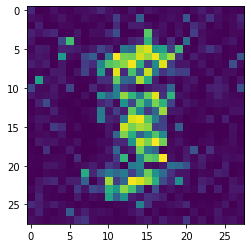

In [70]:
plt.imshow(new_gen_imgs)

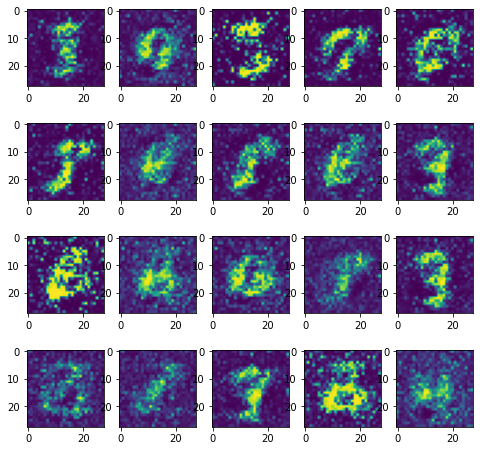

In [73]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(8, 8))
columns = 5
rows = 4
for i in range(1, columns*rows +1):
    fig.add_subplot(rows, columns, i)
    a = np.reshape(gen_imgs[i-1], (28,28))
    plt.imshow(a)
plt.show()
